# Practical Deep Learning Workshop 2021
## Assignment 3 - Word Embeddings
 
### Authors:
 
1.   Chen Doytshman 205644941
2.   Naor Kolet 205533060


# 0. Imports

In [112]:
import pandas as pd
import numpy as np
 
# TensorFlow
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, Concatenate
from tensorflow.keras.layers import Dropout, Dense, Lambda, Multiply, Subtract, Flatten
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Activation

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Scikit-learn
#from sklearn.

# Plots
import seaborn as sns
import matplotlib.pyplot as plt

# Misc.
import os
import joblib
from tqdm import tqdm_notebook as tqdm

SEED = 42
%matplotlib inline

In [2]:
pd.set_option('display.max_colwidth', 100)

In [3]:
import zipfile
DATA_DIR = 'home-depot-product-search-relevance'

files = [f for f in os.listdir(DATA_DIR) if f.endswith('zip')]
for file in tqdm(files):
    with zipfile.ZipFile(f'{DATA_DIR}/{file}') as zf:
        zf.extractall(DATA_DIR)
        os.remove(f'{DATA_DIR}/{file}')

# 0.1 Data Preparation, EDA

Let's load the data:

In [49]:
train_df = pd.read_csv(f'{DATA_DIR}/train.csv', index_col='id', encoding='latin-1')
product_desc_df = pd.read_csv(f'{DATA_DIR}/product_descriptions.csv', index_col='product_uid')
attributes_df = pd.read_csv(f'{DATA_DIR}/attributes.csv', index_col=['product_uid'], dtype={'product_uid': 'Int64'})

In [5]:
test_path = f'{DATA_DIR}/test_labels.csv'
if os.path.exists(test_path):
    test_df = pd.read_csv(test_path)
else:
    test_df = pd.read_csv(f'{DATA_DIR}/test.csv', index_col='id', encoding='latin-1')
    sol = pd.read_csv(f'{DATA_DIR}/solution.csv', index_col='id', encoding='latin-1')
    test_df = test_df[sol.relevance != -1]
    test_df = test_df.join(sol.relevance, on='id')
    test_df.to_csv(test_path)

In [6]:
train_df.head()

,product_uid,product_title,search_term,relevance
id,,,,
2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00
3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50
9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 Tugboat Wood and Concrete Coating,deck over,3.00
16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Kit in Chrome (Valve Not Included),rain shower head,2.33
17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Kit in Chrome (Valve Not Included),shower only faucet,2.67


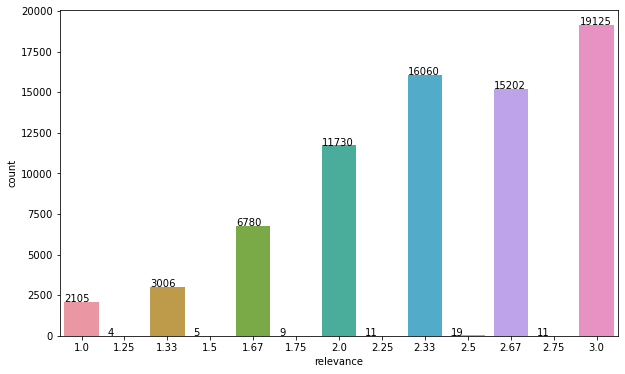

In [7]:
plt.figure(figsize=(10,6))
ax = sns.countplot(data=train_df, x="relevance")

relevance_values = train_df["relevance"].value_counts().sort_index()

for p, label in zip(ax.patches, relevance_values):
    ax.annotate(label, (p.get_x(), p.get_height()+0.5))

In [8]:
product_desc_df.head()

,product_description
product_uid,
100001,"Not only do angles make joints stronger, they also provide more consistent, straight corners. Si..."
100002,"BEHR Premium Textured DECKOVER is an innovative solid color coating. It will bring your old, wea..."
100003,"Classic architecture meets contemporary design in the Ensemble Curve series, made of solid Vikre..."
100004,The Grape Solar 265-Watt Polycrystalline PV Solar Panel bonus pack bundles 4 Grape Solar 265-Wat...
100005,Update your bathroom with the Delta Vero Single-Handle Shower Faucet Trim Kit in Chrome. It has ...


In [9]:
product_desc_df.iloc[0, 0]

'Not only do angles make joints stronger, they also provide more consistent, straight corners. Simpson Strong-Tie offers a wide variety of angles in various sizes and thicknesses to handle light-duty jobs or projects where a structural connection is needed. Some can be bent (skewed) to match the project. For outdoor projects or those where moisture is present, use our ZMAX zinc-coated connectors, which provide extra resistance against corrosion (look for a "Z" at the end of the model number).Versatile connector for various 90 connections and home repair projectsStronger than angled nailing or screw fastening aloneHelp ensure joints are consistently straight and strongDimensions: 3 in. x 3 in. x 1-1/2 in.Made from 12-Gauge steelGalvanized for extra corrosion resistanceInstall with 10d common nails or #9 x 1-1/2 in. Strong-Drive SD screws'

In [10]:
attributes_df[attributes_df.index.isin([100001])]

,name,value
product_uid,,
100001,Bullet01,Versatile connector for various 90° connections and home repair projects
100001,Bullet02,Stronger than angled nailing or screw fastening alone
100001,Bullet03,Help ensure joints are consistently straight and strong
100001,Bullet04,Dimensions: 3 in. x 3 in. x 1-1/2 in.
100001,Bullet05,Made from 12-Gauge steel
100001,Bullet06,Galvanized for extra corrosion resistance
100001,Bullet07,Install with 10d common nails or #9 x 1-1/2 in. Strong-Drive SD screws
100001,Gauge,12
100001,Material,Galvanized Steel


def concat_attr(record):
    name, value = record
    name = f'{name} ' if not name.startswith('Bullet') else '' # Delete name if it's a "Bullet.."
    return f'{name}{value} ;'

product_groups = attributes_df.groupby('product_uid')
for product_uid, df in product_groups:
    joined_attrs = ' '.join(map(concat_attr, df.values))
    product_desc_df.loc[product_uid, 'concat_desc'] = joined_attrs

product_desc_df

TODO: explain the connection between description and attributes

In [56]:
train_df = train_df.join(product_desc_df['product_description'], on='product_uid')
train_df['product_description'] = train_df['product_title'] + ' : ' + train_df['product_description']
train_df = train_df[['product_uid', 'search_term', 'product_description', 'relevance']]

# Preprocessing

In [106]:
def tokenize_serie(serie):
    serie = pd.Series(map(lambda x: list(map(ord, list(x))), serie.values), index=serie.index)
    max_len = min(serie.apply(len).max(), 1500)
    return pad_sequences(serie, max_len, padding='post')

In [107]:
train_st = tokenize_serie(train_df['search_term'])
train_desc = tokenize_serie(train_df['product_description'])

train_st.shape, train_desc.shape

((74067, 60), (74067, 1500))

# Character level LSTM

## 1. Using character level processing to predict search relevance

TODO: explain the replacement of items' description column

In [135]:
from tensorflow.keras import backend as K

def cosine_distance(vests):
    x, y = vests
    x = K.l2_normalize(x, axis=-1)
    y = K.l2_normalize(y, axis=-1)
    return -K.mean(x * y, axis=-1, keepdims=True)

def cos_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0],1)

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 


https://github.com/prabhnoor0212/Siamese-Network-Text-Similarity

In [101]:
from sklearn.metrics import roc_auc_score

def auroc(y_true, y_pred):
    return tf.py_function(roc_auc_score, (y_true, y_pred), tf.double)

In [152]:
sm = 0

def common_model(length):
    global sm
    inp = Input(shape=(length, 1))
    X = Conv1D(64, 10, activation='relu')(inp)
    X = MaxPooling1D()(X)
    X = Flatten()(X)
    X = Activation('relu')(X)
    X = Dense(128, activation='relu')(X)
    
    sm += 1
    return Model(inp, X, name=f'siamese_model_{sm}')

In [153]:
common_model(128).summary()

Model: "siamese_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_75 (InputLayer)        [(None, 128, 1)]          0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 119, 64)           704       
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 59, 64)            0         
_________________________________________________________________
flatten_60 (Flatten)         (None, 3776)              0         
_________________________________________________________________
activation_5 (Activation)    (None, 3776)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               483456    
Total params: 484,160
Trainable params: 484,160
Non-trainable params: 0
_____________________________________________

In [157]:
def init_siamese_model_v2(search_term_len, product_description_len, output=None):
    input_1 = Input(shape=(search_term_len, 1))
    input_2 = Input(shape=(product_description_len, 1))


#     common_embed = Embedding(
#         name="synopsis_embedd",
#         input_dim =len(t.word_index)+1,
#         output_dim=len(embeddings_index['no']),
#         input_length = train_q1_seq.shape[1],
#         trainable=False) 
    
    lstm_1 = LSTM(128)(input_1)
    lstm_2 = LSTM(128)(input_2)
    
    expand_layer = Lambda(lambda tensor: tensor[...,np.newaxis],name="expand_dim_layer")
    
    expended_1 = expand_layer(lstm_1)
    expended_2 = expand_layer(lstm_2)
    
    sm = common_model(128)

    vector_1 = sm(expended_1)
    
    vector_2 = sm(expended_2)
    
    x3 = Subtract()([vector_1, vector_2])
    x3 = Multiply()([x3, x3])

    x1_ = Multiply()([vector_1, vector_1])
    x2_ = Multiply()([vector_2, vector_2])
    x4 = Subtract()([x1_, x2_])
    
    x5 = Lambda(cosine_distance, output_shape=cos_dist_output_shape)([vector_1, vector_2])

    conc = Concatenate(axis=-1)([x5,x4, x3])

    x = Dense(100, activation="relu")(conc)
    x = Dropout(0.01)(x)
    out = Dense(1, activation="relu", name = 'out')(x)

    model = Model([input_1, input_2], out)

    model.compile(loss='mse', optimizer=Adam(0.00001))
    
    return model

In [140]:
def init_siamese_model(search_term_len, product_description_len, output=None):
    input_1 = Input(shape=(search_term_len, 1))
    input_2 = Input(shape=(product_description_len, 1))


#     common_embed = Embedding(
#         name="synopsis_embedd",
#         input_dim =len(t.word_index)+1,
#         output_dim=len(embeddings_index['no']),
#         input_length = train_q1_seq.shape[1],
#         trainable=False) 
    
    vector_1 = LSTM(128)(input_1)
    vector_2 = LSTM(128)(input_2)

    x3 = Subtract()([vector_1, vector_2])
    x3 = Multiply()([x3, x3])

    x1_ = Multiply()([vector_1, vector_1])
    x2_ = Multiply()([vector_2, vector_2])
    x4 = Subtract()([x1_, x2_])
    
    #https://stackoverflow.com/a/51003359/10650182
    x5 = Lambda(cosine_distance, output_shape=cos_dist_output_shape)([vector_1, vector_2])

    conc = Concatenate(axis=-1)([x5,x4, x3])

    x = Dense(100, activation="relu", name='conc_layer')(conc)
    x = Dropout(0.01)(x)
    out = Dense(1, activation="relu", name = 'out')(x)

    model = Model([input_1, input_2], out)

    model.compile(loss='mse', optimizer=Adam(0.00001))
    
    return model

In [141]:
init_siamese_model(train_st.shape[1],train_desc.shape[1]).summary()

Model: "model_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_61 (InputLayer)           [(None, 60, 1)]      0                                            
__________________________________________________________________________________________________
input_62 (InputLayer)           [(None, 1500, 1)]    0                                            
__________________________________________________________________________________________________
lstm_51 (LSTM)                  (None, 128)          66560       input_61[0][0]                   
__________________________________________________________________________________________________
lstm_52 (LSTM)                  (None, 128)          66560       input_62[0][0]                   
___________________________________________________________________________________________

In [160]:
char_model_v1 = init_siamese_model(train_st.shape[1],train_desc.shape[1])

char_model_v1.fit(
    x=[np.expand_dims(train_st,axis=2), np.expand_dims(train_desc,axis=2)],
    y= train_df.relevance,
    epochs=10,
    batch_size=128,
    validation_split=0.23
)

Epoch 1/10
446/446 [==============================] - 45s 100ms/step - loss: 4.8879 - val_loss: 0.4092
Epoch 2/10
446/446 [==============================] - 36s 80ms/step - loss: 0.2994 - val_loss: 0.3188
Epoch 3/10
446/446 [==============================] - 32s 73ms/step - loss: 0.2871 - val_loss: 0.3100
Epoch 4/10
446/446 [==============================] - 32s 73ms/step - loss: 0.2864 - val_loss: 0.3117
Epoch 5/10
446/446 [==============================] - 32s 72ms/step - loss: 0.2859 - val_loss: 0.3045
Epoch 6/10
446/446 [==============================] - 32s 72ms/step - loss: 0.2856 - val_loss: 0.3145
Epoch 7/10
446/446 [==============================] - 32s 73ms/step - loss: 0.2853 - val_loss: 0.3153
Epoch 8/10
446/446 [==============================] - 32s 72ms/step - loss: 0.2842 - val_loss: 0.3064
Epoch 9/10
446/446 [==============================] - 32s 72ms/step - loss: 0.2842 - val_loss: 0.3095
Epoch 10/10
446/446 [==============================] - 32s 72ms/step - loss: 0.28

In [158]:
init_siamese_model_v2(train_st.shape[1],train_desc.shape[1]).summary()

Model: "model_27"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_82 (InputLayer)           [(None, 60, 1)]      0                                            
__________________________________________________________________________________________________
input_83 (InputLayer)           [(None, 1500, 1)]    0                                            
__________________________________________________________________________________________________
lstm_65 (LSTM)                  (None, 128)          66560       input_82[0][0]                   
__________________________________________________________________________________________________
lstm_66 (LSTM)                  (None, 128)          66560       input_83[0][0]                   
___________________________________________________________________________________________

In [159]:
char_model = init_siamese_model_v2(train_st.shape[1],train_desc.shape[1])

char_model.fit(
    x=[np.expand_dims(train_st,axis=2), np.expand_dims(train_desc,axis=2)],
    y= train_df.relevance,
    epochs=10,
    batch_size=128,
    validation_split=0.23
)

Epoch 1/10
446/446 [==============================] - 38s 86ms/step - loss: 5.4949 - val_loss: 4.4102
Epoch 2/10
446/446 [==============================] - 33s 73ms/step - loss: 0.4007 - val_loss: 0.3143
Epoch 3/10
446/446 [==============================] - 33s 74ms/step - loss: 0.2884 - val_loss: 0.3079
Epoch 4/10
446/446 [==============================] - 33s 74ms/step - loss: 0.2856 - val_loss: 0.3156
Epoch 5/10
446/446 [==============================] - 33s 74ms/step - loss: 0.2838 - val_loss: 0.3140
Epoch 6/10
446/446 [==============================] - 33s 74ms/step - loss: 0.2835 - val_loss: 0.3010
Epoch 7/10
446/446 [==============================] - 33s 74ms/step - loss: 0.2832 - val_loss: 0.2978
Epoch 8/10
446/446 [==============================] - 33s 74ms/step - loss: 0.2825 - val_loss: 0.3095
Epoch 9/10
446/446 [==============================] - 33s 74ms/step - loss: 0.2810 - val_loss: 0.2927
Epoch 10/10
446/446 [==============================] - 33s 74ms/step - loss: 0.279